In [29]:
import pandas as pd 
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import seaborn as sns


In [30]:
LOW_QUANTILE = 0.25
HIGH_QUANTILE = 0.2501

# Create a Folder to Store the Results
import os

if not os.path.exists("Results" + "_" + str(LOW_QUANTILE) + "_" + str(HIGH_QUANTILE)):
    os.mkdir("Results" + "_" + str(LOW_QUANTILE) + "_" + str(HIGH_QUANTILE))
    
save_path = "Results" + "_" + str(LOW_QUANTILE) + "_" + str(HIGH_QUANTILE) + "/"

## Data

### mRNA Expression Data

In [31]:
mRNA_df = pd.read_csv('Depmap Melanoma mRNA.csv')
mRNA_df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [32]:
full_mRNA_df = pd.read_csv('Depmap Pancancer mRNA.csv')
full_mRNA_df.drop(['Unnamed: 0'], axis=1, inplace=True)

### Gene Dependency Data

In [33]:
# SWAP THIS TO RUN WITH GENE EFFECT
dependency_df = pd.read_csv('Depmap Melanoma Gene Effect.csv')
dependency_df.drop(['Unnamed: 0'], axis=1, inplace=True)
print(dependency_df.shape)

(60, 17454)


### Cell Lines Data

In [34]:
cell_df = pd.read_csv(r'C:\Users\commo\OneDrive - University of Virginia\School\STEM\BME\BME 4700 - Systems Bioengineering\CCLE Chromatin Analysis\Raw Data\Melanoma Depmap Cell Lines.csv')
cell_df.drop(['Unnamed: 0'], axis=1, inplace=True)

# Filter for BRAF
cell_df = cell_df[cell_df['BRAF_mut'].notna()]
print(cell_df.shape)

(81, 9)


### Chromatin Modifying Genes

In [35]:
chromatin_genes_df = pd.read_csv("Chromatin Genes.csv")
chromatin_genes_df.head(5)

,Gene
0,ACTB
1,ACTL6A
2,ACTL6B
3,AKAP8
4,AKAP8L


### BRAF Filter

In [37]:
full_mRNA_df = full_mRNA_df[full_mRNA_df['Cell Line'].isin(cell_df['Barcode'])]
print(full_mRNA_df.shape)

mRNA_df = mRNA_df[mRNA_df['Cell Line'].isin(cell_df['CellLine'])]
print(mRNA_df.shape)

dependency_df = dependency_df[dependency_df['Cell Line'].isin(cell_df['CellLine'])]
print(dependency_df.shape)

(63, 19194)
(47, 19194)
(47, 17454)


## Analysis

### Validating Assumptions / mRNA Quartiles

#### Normality Test (Shapiro-Wilk Test) for mRNA Expression and Gene Dependency

In [38]:
# Shapiro-Wilk Test for Normality for All Genes in Gene mRNA Expression Data
# Interpretation: p-value < 0.05, therefore  mRNA data is not normally distributed
results = []
for gene in mRNA_df.columns[1:]:
    results.append((gene,stats.shapiro(mRNA_df[gene])[0],stats.shapiro(mRNA_df[gene])[1]))
    
shapiro_df = pd.DataFrame(results, columns=['Gene','W-Stat','p-value'])
print(shapiro_df.shape)
print(mRNA_df.shape)
print('number of genes that are normally distributed: ', len(shapiro_df[shapiro_df['p-value'] > 0.05]))
    

c:\Users\commo\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_morestats.py:1797: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


(19193, 3)
(47, 19194)
number of genes that are normally distributed:  8576


In [39]:
# Shapiro-Wilk Test for Normality for All Genes in Gene Dependency Data
# Interpretation: p-value < 0.05, therefore  dependency data is not normally distributed

results = []
for gene in dependency_df.columns[1:]:
    results.append((gene,stats.shapiro(dependency_df[gene])[0],stats.shapiro(dependency_df[gene])[1]))
    
shapiro_df = pd.DataFrame(results, columns=['Gene','W-Stat','p-value'])
print(shapiro_df.shape)
print(dependency_df.shape)
print('number of genes that are normally distributed: ', len(shapiro_df[shapiro_df['p-value'] > 0.05]))

(17453, 3)
(47, 17454)
number of genes that are normally distributed:  13370


#### mRNA Quartiles (Pancancer mRNA & Melanoma mRNA)

##### Chromatin mRNA Subset

In [40]:
mRNA_genes = mRNA_df.columns[1:].tolist()
chromatin_genes = chromatin_genes_df['Gene'].tolist()
intersection = list(set(chromatin_genes).intersection(mRNA_genes))

chromatin_vip_df = mRNA_df[intersection]

print(chromatin_vip_df.shape)
print(len(chromatin_genes))

(47, 497)
499


### Correlation for Chronos Scores by mRNA Groups

#### T-Tests

In [41]:
# Concatenate the vip genes dataframes
vip_genes = pd.Series(list(chromatin_vip_df.columns))
vip_genes.sort_values(inplace=True)
vip_genes.reset_index(drop=True, inplace=True)
print(vip_genes.shape)
vip_genes.head(5)

(497,)


0      ACTB
1    ACTL6A
2    ACTL6B
3     AKAP8
4    AKAP8L
dtype: object

##### Pairwise Correlations

In [42]:
 # Create a Matrix of Gene x Gene
gene_effect_matrix = np.zeros((vip_genes.shape[0], vip_genes.shape[0])) 
print(gene_effect_matrix.shape)

# Iterate through the genes
# For each gene
# Iterate through the other expression cell lines and then grab the gene dependency values
# perform correlations between the genes
for gene in vip_genes:
    
    for gene2 in vip_genes:
        
        
        # Correlation
        corr = stats.pearsonr(mRNA_df[gene], dependency_df[gene2])
        
        # Add the t-statistic to the gene effect matrix
        gene_effect_matrix[vip_genes[vip_genes == gene].index[0], vip_genes[vip_genes == gene2].index[0]] = corr[0]
        
# Save
np.savetxt(save_path + 'mRNA vs. Gene Dependency Matrix.csv', gene_effect_matrix, delimiter=",")

(497, 497)


In [43]:
# Convert to PD
gene_effect_matrix_df = pd.DataFrame(gene_effect_matrix, columns=vip_genes, index=vip_genes)

# Remove NaN rows
gene_effect_matrix_plot = gene_effect_matrix[~np.isnan(gene_effect_matrix).any(axis=1)]

In [44]:
gene_effect_matrix_df

,ACTB,ACTL6A,ACTL6B,AKAP8,AKAP8L,ALKBH1,APBB1,APLNR,APP,ARID1A,...,YEATS4,ZBTB33,ZBTB4,ZBTB7B,ZBTB7C,ZMPSTE24,ZMYND11,ZMYND8,ZNHIT1,ZZZ3
ACTB,-0.246005,-0.444838,0.050370,0.057529,0.034514,-0.022959,-0.167386,-0.090076,-0.019705,0.006366,...,-0.243703,-0.138265,-0.199143,-0.045968,-0.001189,-0.132658,-0.019906,0.012599,-0.002649,-0.323247
ACTL6A,-0.059181,-0.121595,0.115716,-0.136316,0.056006,0.128141,-0.258240,0.175038,-0.087387,0.088694,...,0.052706,-0.077667,-0.041976,-0.053517,-0.037143,-0.024300,0.085826,0.055555,0.140646,-0.237199
ACTL6B,-0.134469,0.042883,-0.122391,0.211729,0.173943,-0.239612,0.136550,-0.053162,-0.009763,0.203888,...,-0.143695,-0.192624,-0.239110,0.054655,0.195923,-0.136455,0.022800,0.022404,0.217583,-0.031496
AKAP8,-0.150511,-0.109789,-0.090214,-0.048259,0.079156,-0.019193,0.087374,0.104690,-0.081388,0.279711,...,-0.040503,-0.148932,-0.030260,-0.034874,0.092079,-0.002548,-0.137262,-0.164606,0.069131,-0.076989
AKAP8L,-0.066019,0.065695,-0.230080,-0.136112,-0.061252,-0.075218,0.277213,0.251525,-0.005503,0.094000,...,0.157626,-0.072447,-0.077568,-0.109816,-0.031416,0.235911,-0.147637,-0.105429,0.017862,0.312767
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZMPSTE24,0.150851,0.134067,-0.273188,0.050363,-0.086980,-0.082683,0.089042,-0.189668,-0.105061,-0.064160,...,-0.079131,0.095190,-0.078316,-0.257493,0.229879,0.128276,-0.022422,-0.090749,-0.017020,0.114750
ZMYND11,-0.270434,0.077758,0.200450,-0.127706,0.047919,0.208879,-0.179863,0.095005,-0.323564,0.170232,...,0.161475,-0.145585,-0.013518,-0.067887,0.008623,0.112533,0.003888,0.030644,-0.084115,-0.359323
ZMYND8,-0.015703,0.155330,-0.027268,0.206559,0.094755,0.079795,0.110940,0.008559,-0.236488,0.135403,...,0.169629,-0.233949,0.151296,0.100018,0.033401,0.144283,-0.223437,-0.071860,0.138095,0.073368
ZNHIT1,0.066389,-0.049113,-0.194795,0.011004,0.192071,0.008888,-0.148318,-0.034818,-0.058634,-0.141275,...,-0.171536,-0.064645,-0.014177,0.335095,-0.053417,-0.107602,-0.097215,0.013722,-0.039609,0.128402


In [45]:
POS_CORR = 0.5
NEG_CORR = -0.5
# Rows where the p-value is less than 0.05
significant_rows_df = gene_effect_matrix_df[(gene_effect_matrix_df < NEG_CORR) | (gene_effect_matrix_df > POS_CORR)]
# Fill NAN with 1
significant_rows_df = significant_rows_df.dropna(axis=0, how='all').dropna(axis=1, how='all')
significant_rows_df.fillna(0, inplace=True)
significant_rows_df.head(5)



,ATAD2,BAZ1B,BAZ2B,BPTF,BRD1,BRD3,BRD9,CBX5,CENPA,CHAF1A,...,SSRP1,STAG1,TAF5L,TET2,TRERF1,TRMT112,USP22,VPS72,YEATS4,ZMYND8
APLNR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
APP,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ATAD2B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BCOR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BRD2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<AxesSubplot: >

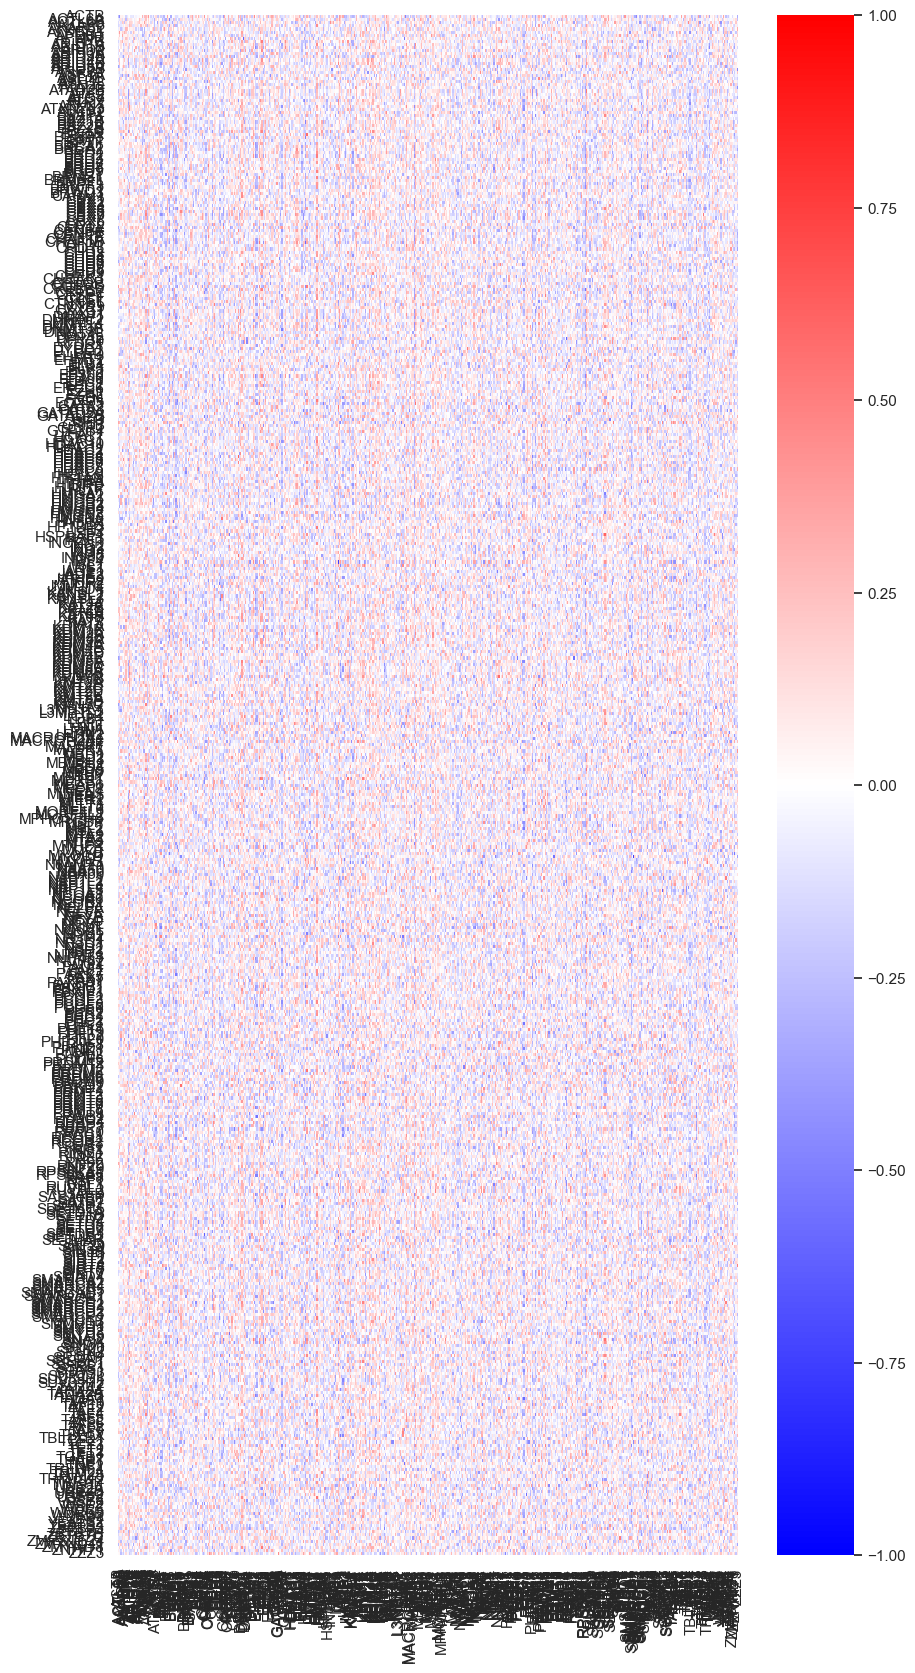

In [46]:
# All Rows
sns.set(font_scale=1)
plt.figure(figsize=(10,20))
sns.heatmap(gene_effect_matrix_df, vmin=-1,vmax=1, cmap='bwr', xticklabels=True, yticklabels=True)

Text(0.5, 1.0, 'mRNA vs. Gene Dependency Heatmap (Positive or Negative Correlates)')

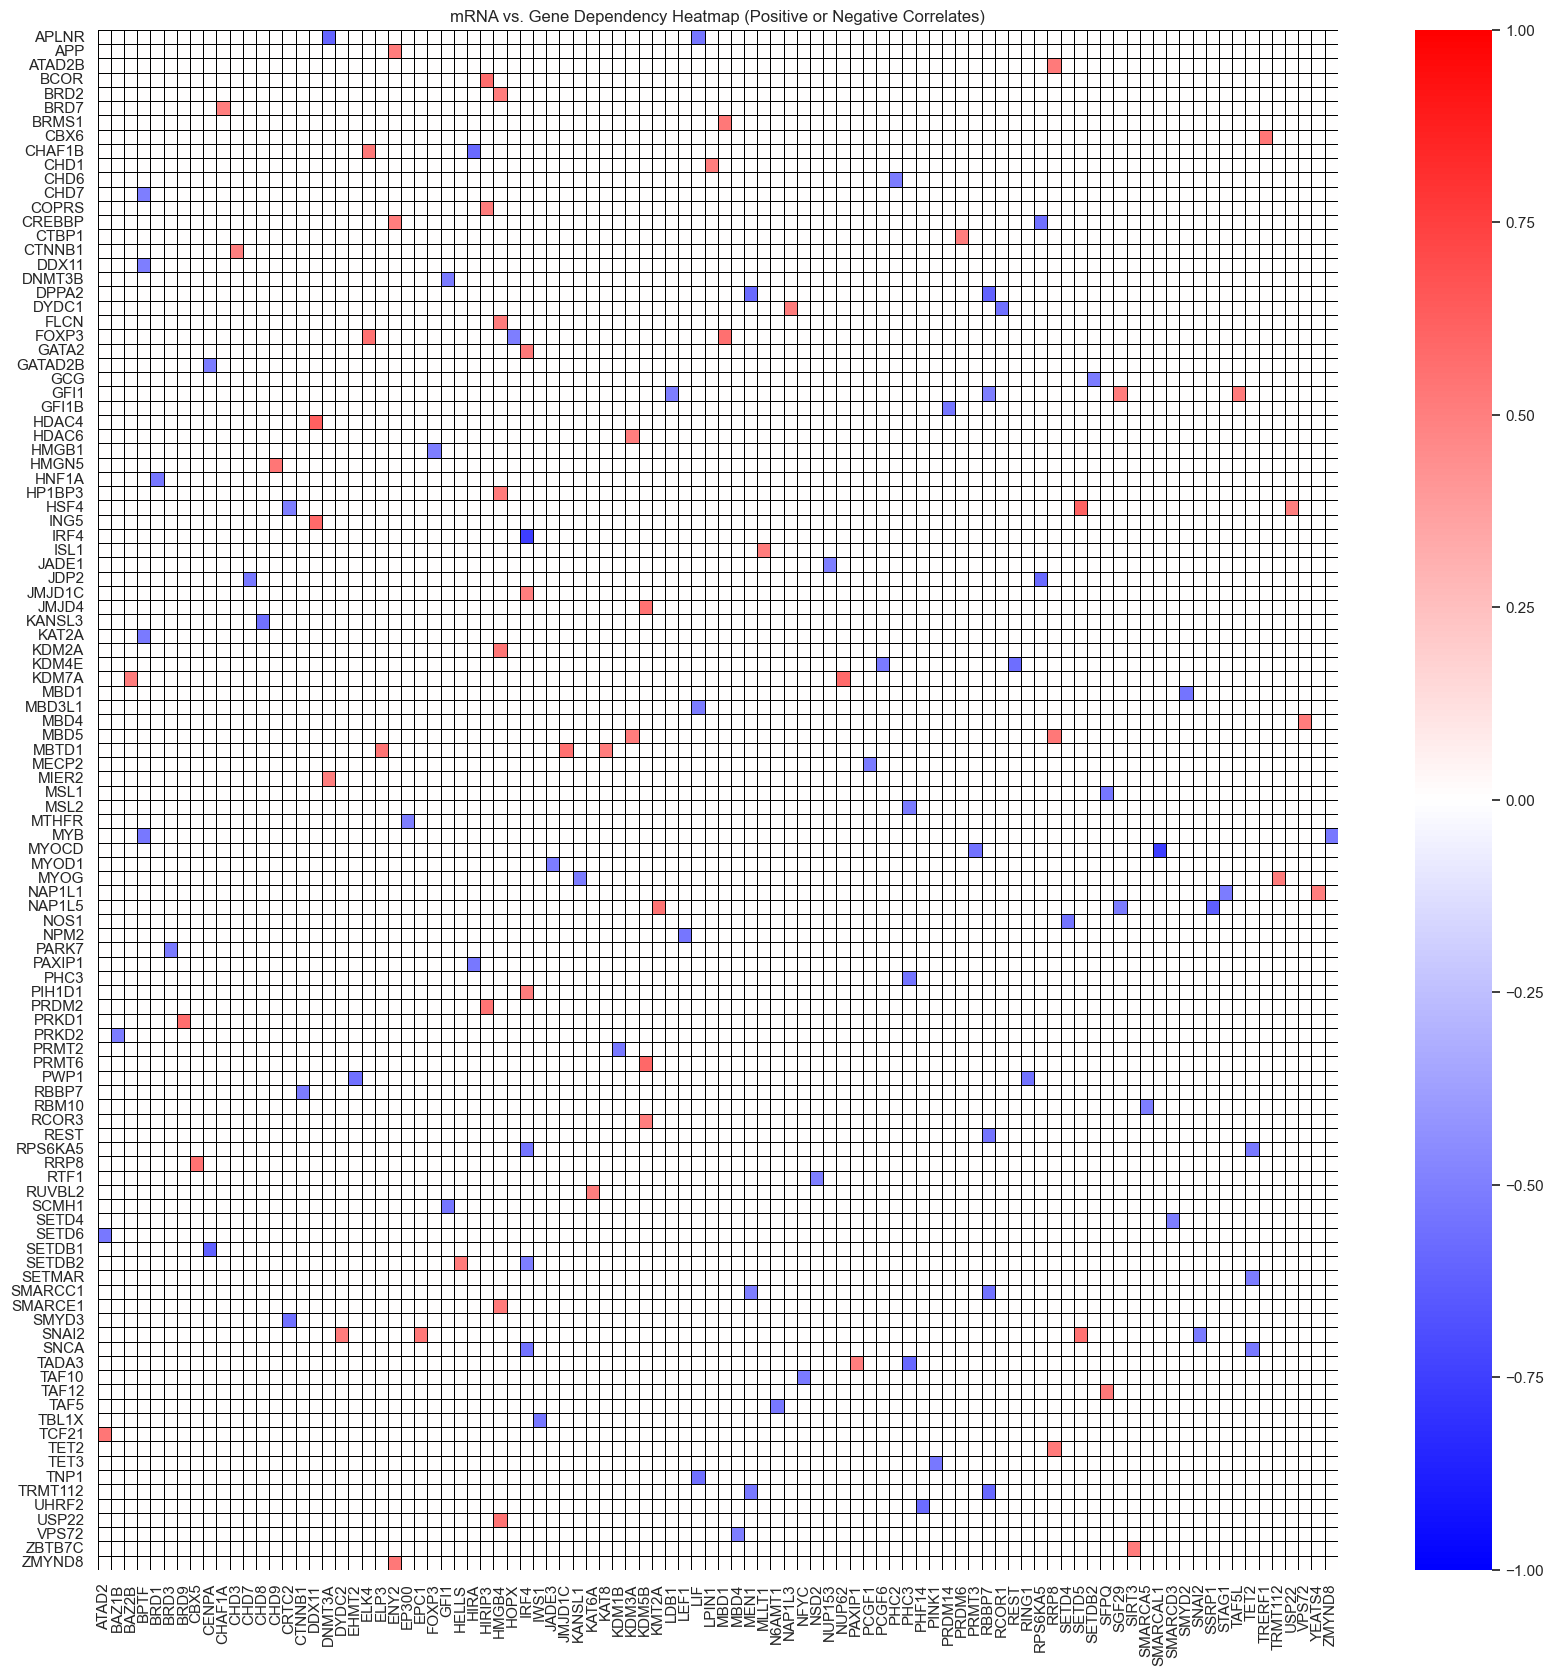

In [53]:
# Rows that were < .05
sns.set(font_scale=1)
plt.figure(figsize=(20,20))
sns.heatmap(significant_rows_df, vmin=-1, vmax=1, cmap='bwr', xticklabels=True, yticklabels=True, linewidths=0.5, linecolor='black')
plt.title('mRNA vs. Gene Dependency Heatmap (Positive or Negative Correlates)')


In [48]:
for gene in significant_rows_df.dropna(axis=0, how='all').dropna(axis=1, how='all').columns:
    with open("GeneCards Lookup.txt", "a") as file:
        file.write(gene + ':' + '\n')
        file.write('https://www.genecards.org/cgi-bin/carddisp.pl?gene=' + gene + '\n')
        file.write('\n')
    
file.close()

for gene in significant_rows_df.dropna(axis=0, how='all').dropna(axis=1, how='all').index:
    with open("GeneCards Lookup.txt", "a") as file:
        file.write(gene + ':' + '\n')
        file.write('https://www.genecards.org/cgi-bin/carddisp.pl?gene=' + gene + '\n')
        file.write('\n')

flie.close()

NameError: name 'flie' is not defined

(11,)
(49,)
(11,)
(49,)


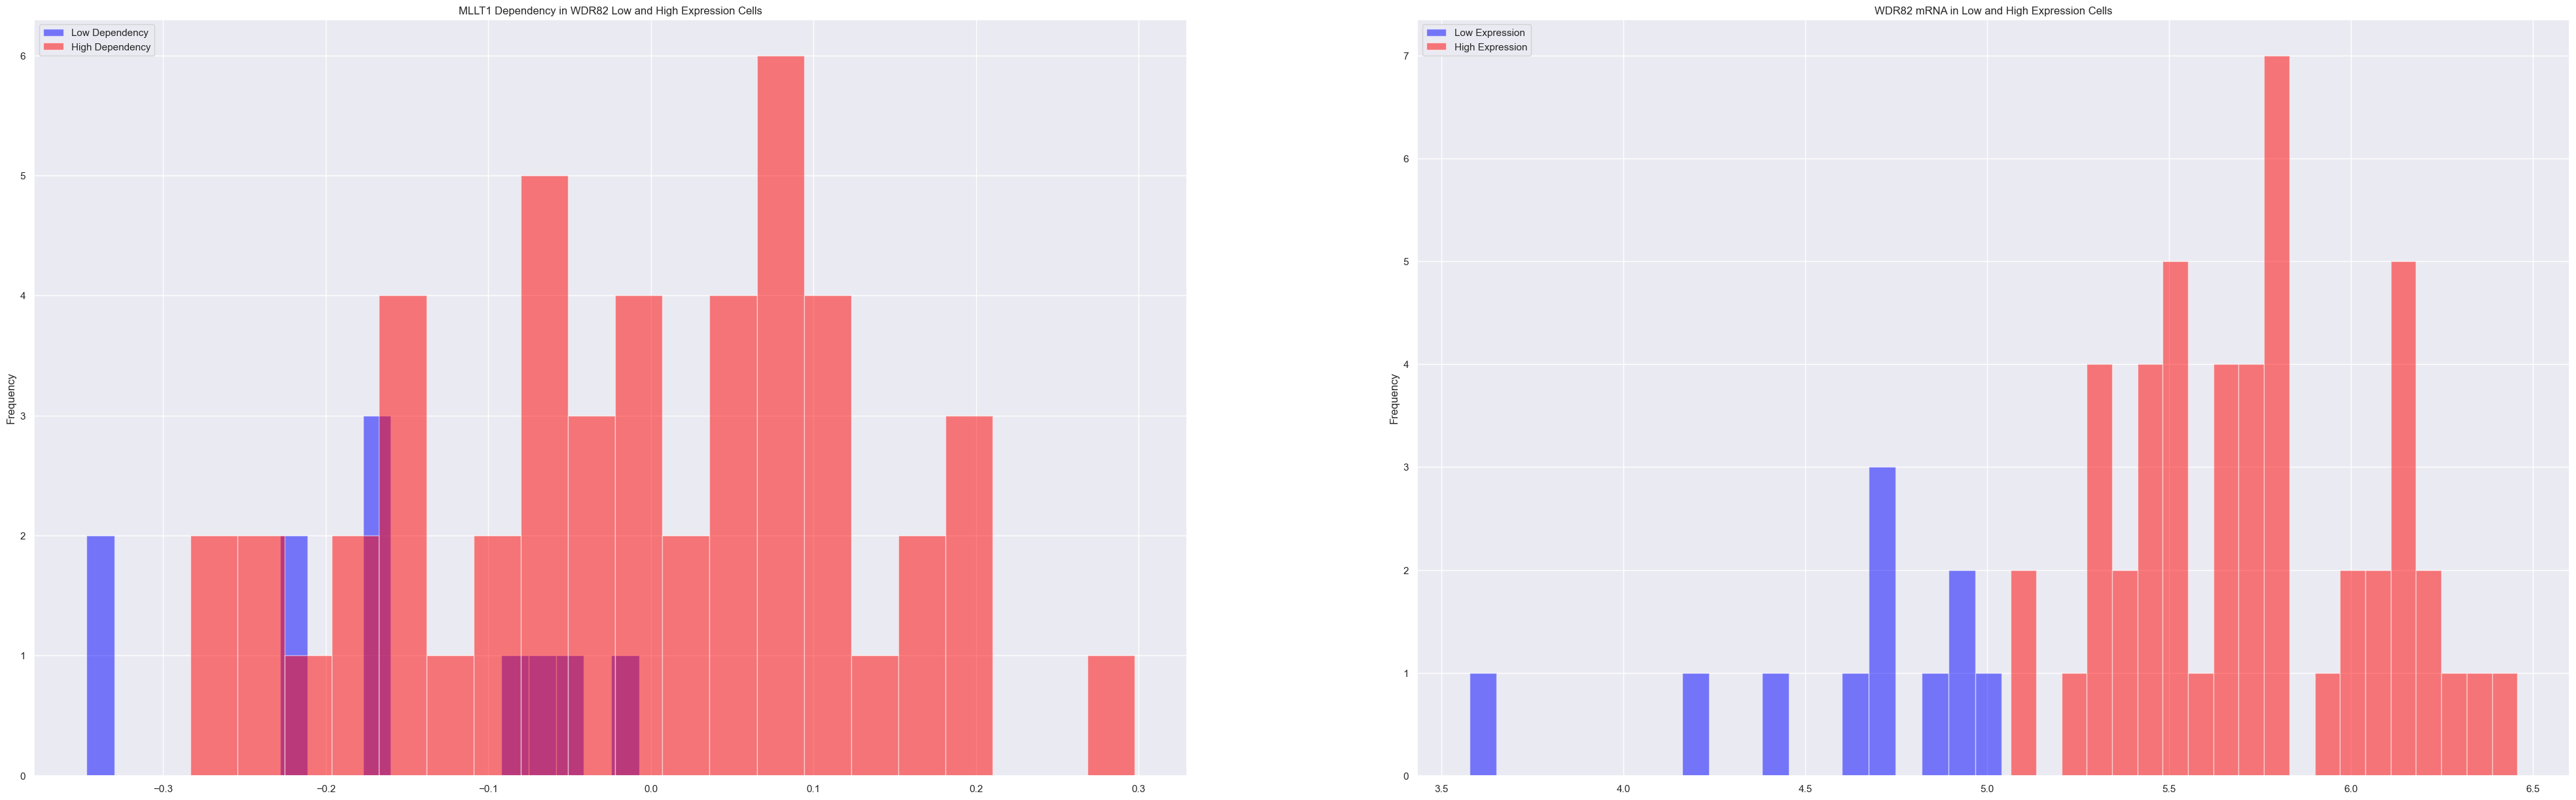

In [ ]:
# Manual Validation
gene = 'WDR82'
gene2 = 'MLLT1'
low_expression = gene_groups[gene_groups[gene] == 'low'].index
high_expression = gene_groups[gene_groups[gene] == 'high'].index


low_expression_dependency = dependency_df.loc[low_expression, gene2]
high_expression_dependency = dependency_df.loc[high_expression, gene2]


# T-Test of Gene Dependency in Low and High Expression Cells
ttest = stats.ttest_ind(low_expression_dependency, high_expression_dependency,  alternative = 'two-sided')

# Add the t-statistic to the gene effect matrix
significant_rows_df[vip_genes[vip_genes == gene].index[0], vip_genes[vip_genes == gene2].index[0]] = ttest[0]

fig,ax = plt.subplots(1,2,figsize=(50,15))

ax[0].hist(low_expression_dependency, bins=20, color='blue', alpha=0.5, label='Low Dependency')
ax[0].hist(high_expression_dependency, bins=20, color='red', alpha=0.5, label='High Dependency')
ax[0].legend(loc='upper left')
ax[0].set_ylabel('Frequency')
ax[0].set_title(gene2 + ' Dependency in ' + gene + ' Low and High Expression Cells')

# mRNA
ax[1].hist(mRNA_df.loc[low_expression, gene], bins=20, color='blue', alpha=0.5, label='Low Expression')
ax[1].hist(mRNA_df.loc[high_expression, gene], bins=20, color='red', alpha=0.5, label='High Expression')
ax[1].legend(loc='upper left')
ax[1].set_ylabel('Frequency')
ax[1].set_title(gene + ' mRNA in Low and High Expression Cells')


print(low_expression.shape)
print(high_expression.shape)
print(low_expression_dependency.shape)
print(high_expression_dependency.shape)
    